# Non-Linear Regression (with multiple features)
## Creating/manufacturing non-linear features from the features that come with the dataset

**ACKNOWLEDGEMENT**

**The code in this notebook contains code from John D. Wittenauer's notebooks on GitHub, Sebastian Raschka's book *Python Machine Learning*, and Sonya Sawtelle's blog. The dataset used is from Andrew Ng's machine learning course on Coursera.**

In [1]:
# Use the functions from another notebook in this notebook
%run Shared-Functions.ipynb

In [2]:
# Import our usual libraries
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
%matplotlib inline

## The Business Problem: Predicting Housing Prices

What's the market value of a house? One way to determine the market value is to collect up the prices of houses based on a few characteristics such as size in square feet and number of bedrooms. Then apply machine learning to "learn" what the price should be based on this data.

The data we have is a well know machine learning dataset of housing prices in Portland, Oregon. Let's refresh our memories of what this dataset looks like.

## Load the Data

In [3]:
import os
# Load the housing prices dataset
file_url = data_dir + os.sep + "portland-house-prices.txt"
# Load the data into a dataframe
data2 = pd.read_csv(file_url, header=None, names=['Size', 'Bedrooms', 'Price'])
data2.head()

,Size,Bedrooms,Price
0,2104,3,399900
1,1600,3,329900
2,2400,3,369000
3,1416,2,232000
4,3000,4,539900


## Step 1: Visualize the Data

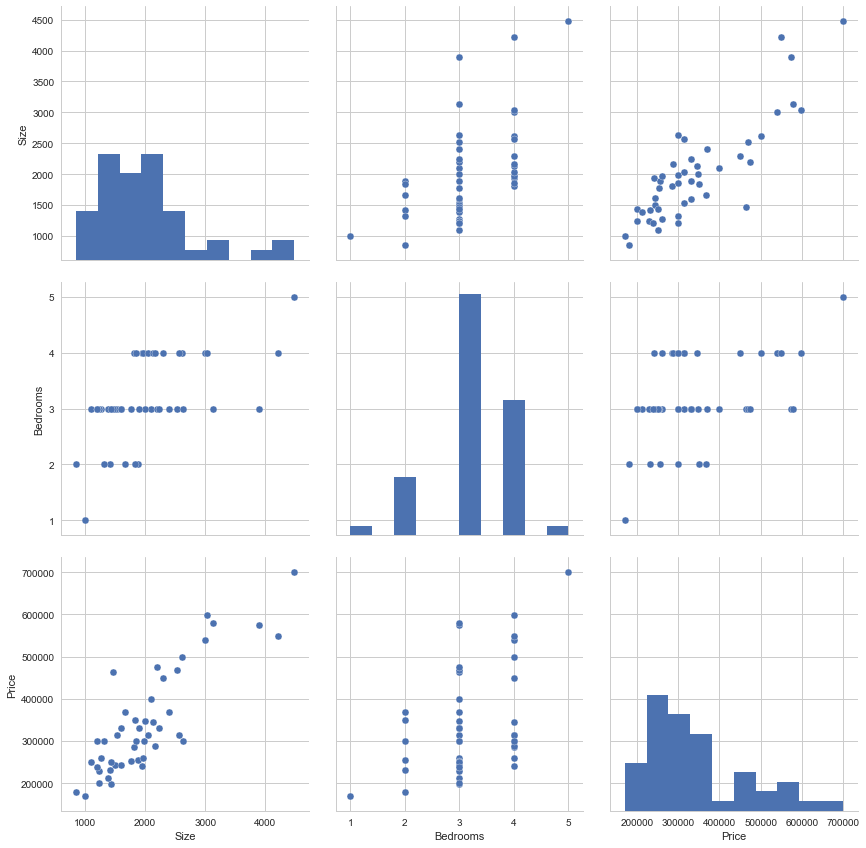

In [4]:
import seaborn as sns
sns.set(style='whitegrid', context='notebook')
cols = ['Size', 'Bedrooms', 'Price']
sns.pairplot(data2[cols], size=4)
plt.show()

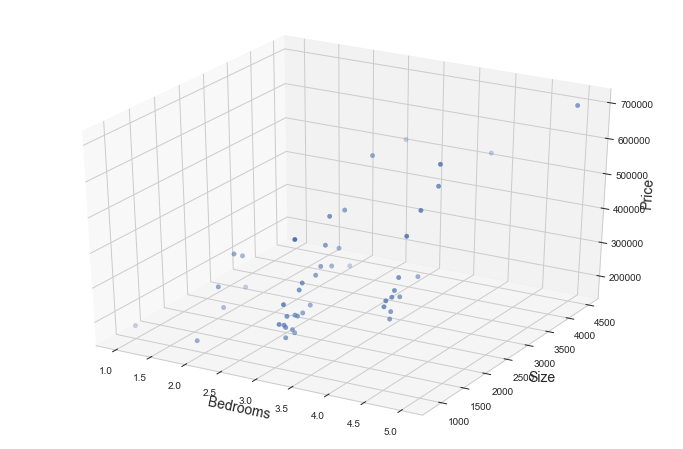

In [5]:
# From https://matplotlib.org/mpl_toolkits/mplot3d/tutorial.html
# 3D scatter plot of size, bedrooms and price
from mpl_toolkits.mplot3d import Axes3D
threeD = plt.figure(figsize=(12,8)).gca(projection='3d')
threeD.scatter(data2['Bedrooms'], data2['Size'], data2['Price'])
threeD.set_xlabel('Bedrooms', fontsize=14)
threeD.set_ylabel('Size', fontsize=14)
threeD.set_zlabel('Price', fontsize=14)
plt.show()

### Exercise 1
Based on the visuals above, how would you describe the data? Write a short paragraph describing the data.

### Rescale/Normalize the Data
Notice that the size of a house in square feet is about 1,000 times the number of bedrooms it has. Similarly, the price of a house is about 100 times the size of the house. This is quite common in many datasets, but when it happens, the iterative method of gradient descent (which we'll use again) becomes inefficient. This is simply a matter of making the computations efficient. To do so, we'll do something called *feature normalization*.

In [6]:
# Normalize the scales in the dataset
# NOTE: the output doesn't have to be rescaled but we've done that here anyway
# If you know statistics: What we're doing is rewriting each value in terms of standard deviation units
data2Norm = (data2 - data2.mean()) / data2.std()
data2Norm.head()

# In Orange use the Preprocessor widget

,Size,Bedrooms,Price
0,0.130010,-0.223675,0.475747
1,-0.504190,-0.223675,-0.084074
2,0.502476,-0.223675,0.228626
3,-0.735723,-1.537767,-0.867025
4,1.257476,1.090417,1.595389


## Step 2: Define the Task You Want to Accomplish

Task = Given the size of a house in square feet and the number of bedrooms it contains, predict the price of the house.

House prices are continuous quantities and so our method of prediction is going to be linear regression. Because we have more than one feature, we'll use linear regression with multiple features.

In addition, we'll make some of our features non-linear (we'll see what that means shortly).

### Step 2a: Identify the Inputs
In this case we have 2 inputs (i.e., 2 features) -- the size and number of bedrooms of the house. 

In [7]:
# Number of columns in the dataset
cols = data2Norm.shape[1]
# Inputs are our first two columns
X = data2Norm.iloc[:, 0:cols-1]
# Add an initial column of 1s to X to keep the notation simple
# X.insert(0,'x0',1)

In [8]:
# First few rows of features (remember it's scaled)
X.head()

,Size,Bedrooms
0,0.130010,-0.223675
1,-0.504190,-0.223675
2,0.502476,-0.223675
3,-0.735723,-1.537767
4,1.257476,1.090417


### Step 2b: Identify the Output
The output is the house price. Let's set it up as a variable y.

In [9]:
# The output -- the price of a house
# Don't need to normalize the output
#y = data2['Price']
y = data2.iloc[:, cols-1:cols]
# First few house prices in the dataset
y.head()

,Price
0,399900
1,329900
2,369000
3,232000
4,539900


## Step 3: Define the Model

### Step 3a: Define the Features

In this case our features are exactly the same as our inputs. We have 2 features: the size of a house in square feet and the number of bedrooms a house has. These are the features encoded in the variables $x_{1}$ and $x_{2}$.

Later we'll see models where the features and the inputs are not one and the same. In these cases the features are constructed by combining inputs in various ways.

### Step 3b: Transform the Inputs Into an Output

When we were doing linear regression with multiple features our model -- the transformation of inputs into the output looked like this:

$$\hat{y} = w_{0} * x_{0}\ +\ w_{1} * x_{1} +\ w_{2} * x_{2}$$

This is linear because there are not squares or cubes or anything like that. But what if we wanted to say that the price of a house is linear with respect to its size but the square of the number of bedrooms? We'd write it like this:

$$\hat{y} = w_{0} * x_{0}\ +\ w_{1} * x_{1} +\ w_{2} * x_{2}^{2}$$

Rather than just writing an expression with multiplication and addition, we now have powers -- in this case, $x_{2}^{2}$.

Acutally, we're free to make the model *anything* we want. It depends on what we think is best for prediction. So, we can make it complicated:

$$\hat{y} = w_{0} * x_{0}\ +\ w_{1} * x_{1} +\ w_{2} * x_{1} * x_{2} +\ w_{3} * x_{1}^2 +\ w_{4} * x_{2}^{5}$$

That seems crazy, but the point is simply that this is our model to choose and we have lots of choices!

### How Non-Linear Terms Fit the Data

To get a feel for how these non-linear models behave, let's look a simplified dataset -- the one we're using but with the number of bedrooms removed. We just have the square footage and the price. This allows us to visualize things in 2 dimensions.

Let's visualize the fit for various degrees of polynomial functions. This is how we're going to make the transformation from inputs to output *non-linear*.

In [10]:
# First drop the Bedrooms column from the data set
# Notice -- this is the raw data -- no scaling yet.
data3 = data2.drop('Bedrooms', axis = 1)
data3.head()

,Size,Price
0,2104,399900
1,1600,329900
2,2400,369000
3,1416,232000
4,3000,539900


In [11]:
# Getting a handle on the simplified dataset
data3.describe()

,Size,Price
count,47.000000,47.000000
mean,2000.680851,340412.659574
std,794.702354,125039.899586
min,852.000000,169900.000000
25%,1432.000000,249900.000000
50%,1888.000000,299900.000000
75%,2269.000000,384450.000000
max,4478.000000,699900.000000


/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:29: RankWarning: Polyfit may be poorly conditioned


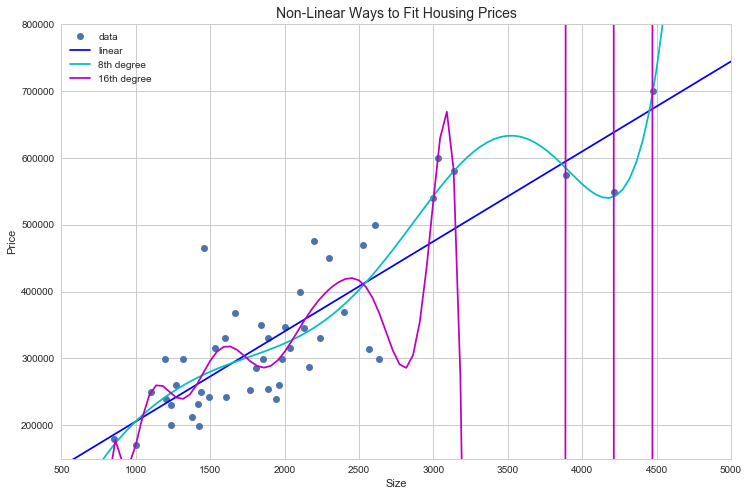

In [31]:
# Using non-linear (polynomial) models to "fit" the simplified dataset

X_p = data3['Size']
y_p = data3['Price']
xx = np.linspace(500, 5000, 100)
#print(xx)

# fit the data with a first degree polynomial
z1 = np.polyfit(X_p, y_p, 1) 
p1 = np.poly1d(z1)

# fit the data with a 2nd degree polynomial
z2 = np.polyfit(X_p, y_p, 2) 
p2 = np.poly1d(z2) # construct the polynomial (note: that's a one in "poly1d")

# fit the data with a 3rd degree polynomial
z3 = np.polyfit(X_p, y_p, 3) 
p3 = np.poly1d(z3) # construct the polynomial

# fit the data with a 4th degree polynomial
z4 = np.polyfit(X_p, y_p, 4) 
p4 = np.poly1d(z4) # construct the polynomial

# fit the data with a 8th degree polynomial - just for the heck of it :-)
z8 = np.polyfit(X_p, y_p, 8) 
p8 = np.poly1d(z8) # construct the polynomial

# fit the data with a 16th degree polynomial - just for the heck of it :-)
z16 = np.polyfit(X_p, y_p, 16) 
p16 = np.poly1d(z16) # construct the polynomial


plt.figure(figsize=(12,8))
plt.plot(X_p, y_p, 'o', label='data')
plt.title('Non-Linear Ways to Fit Housing Prices', fontsize=14)
plt.xlabel('Size')
plt.ylabel('Price')
plt.plot(xx, p1(xx), 'b-', label='linear')
#plt.plot(xx, p2(xx), 'g-', label='2nd degree')
#plt.plot(xx, p3(xx), 'y-', label='3rd degree')
#plt.plot(xx, p4(xx), 'r-', label='4th degree')
plt.plot(xx, p8(xx), 'c-', label='8th degree')
plt.plot(xx, p16(xx), 'm-', label='16th degree')
plt.legend(loc=2)
plt.axis([500,5000,150000,800000]); # Useful for higher degrees of polynomials

And here's what the expression for the 8th-degree non-linear model looks like:

In [33]:
# What does the 8th-degree polynomial expression look like?
print(p8)

            8             7            6            5            4
-6.838e-22 x + 1.913e-17 x - 1.93e-13 x + 9.69e-10 x - 2.73e-06 x
             3         2
 + 0.004578 x - 4.698 x + 2980 x - 7.185e+05


Right. Back to the relatively simpler non-linear model we'd like to try:

$$\hat{y} = w_{0} * x_{0}\ +\ w_{1} * x_{1} +\ w_{2} * x_{2}^{2}$$

What we've done is made the price dependent on the square of the number of the bedrooms. In the linear model price just depended on the number of bedrooms.

In order to implement this model, we'll have to go back to the dataset. In particular, we see that the model is no longer about the feature $x_{2}$. It's now about the feature $x_{2}^{2}$.

So let's change the dataset to reflect that. 

**This is the critical thing to understand**
- Models are schemes for transforming each row of inputs (features) of a dataset into an ouput.
- Case 1: Linear Models. The inputs are given to us -- we just take the dataset and run with it. In this case, we are just building a linear model of that dataset.
- Case 2: Non-Linear Models. We must modify the dataset given to us. We are free to modify it in any way we choose. To make non-liner models, we simply "manufacture" columns in the dataset. Want the model to reflect that price is a function of number of bedrooms squared? Then construct/manufacture this column in the dataset.

In [14]:
# Add a column of bedroom values squared
data2Norm.insert(2, '# Bedrooms Squared', np.power(data2Norm['Bedrooms'], 2))

In [15]:
# Our new dataset will be:
X_2 = data2Norm.drop(['Bedrooms', 'Price'], axis=1)
X_2.head()

,Size,# Bedrooms Squared
0,0.130010,0.050031
1,-0.504190,0.050031
2,0.502476,0.050031
3,-0.735723,2.364727
4,1.257476,1.189008


In [16]:
# Get a handle on our transformed dataset built for a non-linear model.
X_2.describe()

,Size,# Bedrooms Squared
count,4.700000e+01,47.000000
mean,1.889741e-17,0.978723
std,1.000000e+00,1.531979
min,-1.445423e+00,0.050031
25%,-7.155897e-01,0.050031
50%,-1.417900e-01,0.050031
75%,3.376348e-01,1.189008
max,3.117292e+00,8.133098


### Step 3c: Clarify the Parameters of the Model

$w_{0}$, $w_{1}$, and $w_{2}$ are the *parameters* of the model. These parameters can each take on an infinite number of values. In other words they are continuous variables. $w_{0}$ is called the *intercept* or *bias* value.

With our model defined above, we know exactly how to transform an input into an output -- that is, once the values of the parameters are given.

Let's pick a value of X from the dataset, fix a specific value for $w_{0}$ and $w_{1}$, and see what we get for the value of y.

Specifically, let
$\begin{bmatrix}
w_{0} \\
w_{1} \\
w_{2}
\end{bmatrix} = 
\begin{bmatrix}
-10 \\
1 \\
0
\end{bmatrix}$

This means $w_{0}$ is -10, $w_{1}$ is 1, and $w_{2}$ is 0.

Let's try out the scheme for transforming the first few rows of X_2.

In [17]:
# X_2 * W for the first 5 rows of X_2 (more accurately: X_2 * W transpose)
df_addOnes(X_2.iloc[0:5]) * np.matrix('-10;1;0')

matrix([[ -9.86999013],
        [-10.50418984],
        [ -9.49752364],
        [-10.73572306],
        [ -8.74252398]])

In [18]:
# Initialize the parameter values, the learning rate and the number of interations
W_init = [-1, 1.4, 0.5]
learning_rate = 0.005 # the learning rate
num_iters = 10 # number of iterations

# Run gradient descent
# Outputs generated by our model for the first 5 inputs with the specific w values below
W_opt, final_penalty, running_w, running_penalty = gradientDescent(X_2, y, W_init, num_iters, learning_rate)

In [19]:
# These are initial predictions
# Compare these outputs to the actual values of y in the dataset (after de-scaling)
(df_addOnes(X_2.iloc[0:5]) * np.matrix(W_opt))

matrix([[ 17725.45232841],
        [ 14512.11083913],
        [ 19612.6528856 ],
        [ 49189.05851574],
        [ 41078.57121038]])

In general this is going to be far from the actual values; so we know that the values for $W$ in $W_{opt}$ must be quite far from the optimal values for $W$ -- the values that will minimize the cost of getting it wrong.

## Step 4: Define the Penalty for Getting it Wrong

Our cost function is exactly the same as it was before for the single and multiple feature cases. 

The only difference from what we had before is the $w_{2}$ and $x_{2}$ are now added because we have 2 features rather than just one. We'll always have the same number of $w$ and $x$ values if you count the feature $x_{0}$ that we "manufacture" and set to always be equal to 1.

We're going to take $\hat{y}$ -- the predicted price -- for every row of the dataset as below:

$$\hat{y}^{(1)} = w_{0} * x_{0}^{(1)}\ +\ w_{1} * x_{1}^{(1)} +\ w_{2} * (x_{2}^{(1)})^{2}$$
$$\vdots$$
$$\hat{y}^{(m)} = w_{0} * x_{0}^{(m)}\ +\ w_{1} * x_{1}^{(m)} +\ w_{2} * (x_{2}^{(m)})^{2}$$

Then we'll apply the squared penalty function to the actual minus the predicted value for every row and sum these values over all the rows of the dataset.

$$ cost = (\hat{y}^{(1)} - y^{(1)})^{2} + (\hat{y}^{(2)} - y^{(2)})^{2} + \dots + (\hat{y}^{(m)} - y^{(m)})^{2} $$

In [20]:
# Compute the cost for a given set of W values over the entire dataset
# Get X and y in to matrix form
penalty(X_2, y, W_init, squaredPenalty)

65591570707.230721

We don't know yet if this is high or low -- we'll have to try out a whole bunch of $W$ values. Or better yet, we can use pick an iterative method and implement it.

## Step 5: Find the Parameter Values that Minimize the Penalty

Once again, the method that will "learn" the optimal values for $W$ is gradient descent. Let's use it to find the minimum cost and the values of $W$ that result in that minimum cost.

In [21]:
# Set hyper-parameters
num_iters = 2000 # number of iterations
learning_rate = 0.0001 # the learning rate

# Run gradient descent and capture the progression of cost values and the ultimate optimal W values
%time W_opt, final_penalty, running_w, running_penalty = gradientDescent(X_2, y, W_init, num_iters, learning_rate)
# Get the optimal W values and the last few W values and cost values
W_opt, final_penalty, running_w[-5:], running_penalty[-5:]

CPU times: user 612 ms, sys: 5.5 ms, total: 618 ms
Wall time: 646 ms


(matrix([[ 56949.33548917],
         [ 18293.00558079],
         [ 45369.4650552 ]]),
 2.7887028129935843e+17,
 [(matrix([[ 56853.67453276]]),
   matrix([[ 18260.96791939]]),
   matrix([[ 45314.78279793]])),
  (matrix([[ 56877.59536742]]),
   matrix([[ 18268.97881184]]),
   matrix([[ 45328.46372677]])),
  (matrix([[ 56901.512471]]),
   matrix([[ 18276.98871942]]),
   matrix([[ 45342.13774418]])),
  (matrix([[ 56925.42584457]]),
   matrix([[ 18284.99764234]]),
   matrix([[ 45355.80485278]])),
  (matrix([[ 56949.33548917]]),
   matrix([[ 18293.00558079]]),
   matrix([[ 45369.4650552]]))],
 array([  2.79218436e+17,   2.79131340e+17,   2.79044283e+17,
          2.78957263e+17,   2.78870281e+17]))

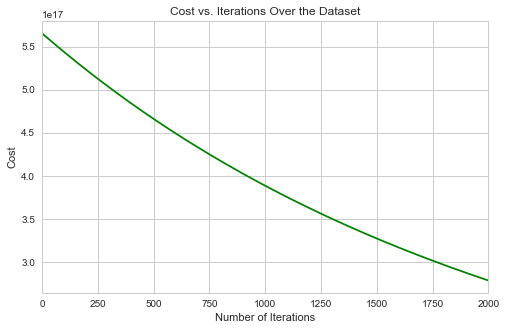

In [22]:
# How the cost changes as the number of iterations increase
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(np.arange(num_iters), running_penalty, 'g')
ax.set_xlabel('Number of Iterations')
ax.set_ylabel('Cost')
plt.xlim(0,num_iters)
ax.set_title('Cost vs. Iterations Over the Dataset');

In [23]:
# Run gradient descent for a few different values of the learning rate
learning_rates = [0.0001, 0.003, 0.005, 0.01, 0.03, 0.1]
gdResults = [gradientDescent(X_2, y, W_init, num_iters, learning_rates[i]) for i in range(len(learning_rates))]
#gdResults

# For each learning rate, get the progression of costs
#  for each iteration
penalty_list = [gdResults[i][3] for i in range(len(gdResults))]
penalty_list[0]

array([  5.65238457e+17,   5.65014098e+17,   5.64789853e+17, ...,
         2.79044283e+17,   2.78957263e+17,   2.78870281e+17])

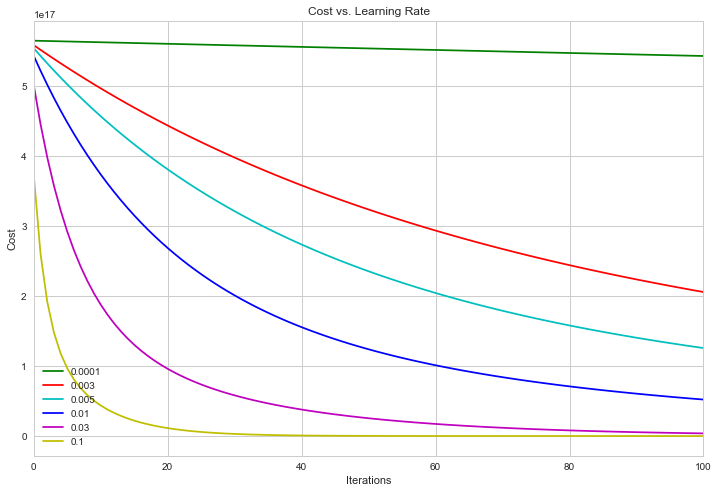

In [24]:
# How the cost of the transformation varies with the learning rate
plot_color_list = ['g', 'r', 'c', 'b', 'm', 'y']
fig, ax = plt.subplots(figsize=(12,8))
[ax.plot(np.arange(num_iters), penalty_list[i], plot_color_list[i], label=learning_rates[i]) for i in range(len(learning_rates))]
ax.set_xlabel('Iterations')
ax.set_ylabel('Cost')
ax.legend()
plt.xlim(0,100)
ax.set_title('Cost vs. Learning Rate');

## Step 6: Use the Model and Optimal Parameter Values to Make Predictions

It looks like a learning rate greater than 0.003 is good enough to get our iterative gradient descent to plunge down to arrive at the lowest cost value and stay there. 

Let's make some predictions...What is our prediction for a house that is 5,000 square feet in size with 4 bedrooms? Let's plug these in to our model and use the optimal $W$ values we've calculated above.

In [42]:
# Change size and num_bedrooms to make distinct predictions
size = 30000
num_bedrooms = 5

# Remember we've run the model using rescaled house sizes and number of bedrooms
# So we should scale the inputs down and then scale the prediction up when we're done
size_scaled = (size - data2.mean()[0])/data2.std()[0]
beds_scaled = (num_bedrooms - data2.mean()[1])/data2.std()[1]

# This is our model -- we're just using it here to make a calculation
pred_price = (W_opt[0] * 1) + (W_opt[1] * size_scaled) + (W_opt[2] * beds_scaled)

# Get the optimal W values into the right form for display
W_opt_display = np.array(W_opt.squeeze()).squeeze()

# Format and print the result
print("Predicted Price: ", '${:8,.0f}'.format(math.ceil(pred_price)))
print("Optimal Parameter Values: {}".format(W_opt))

Predicted Price:  $ 810,549
Optimal Parameter Values: [[ 56949.33548917]
 [ 18293.00558079]
 [ 45369.4650552 ]]


What does this prediction surface look like?

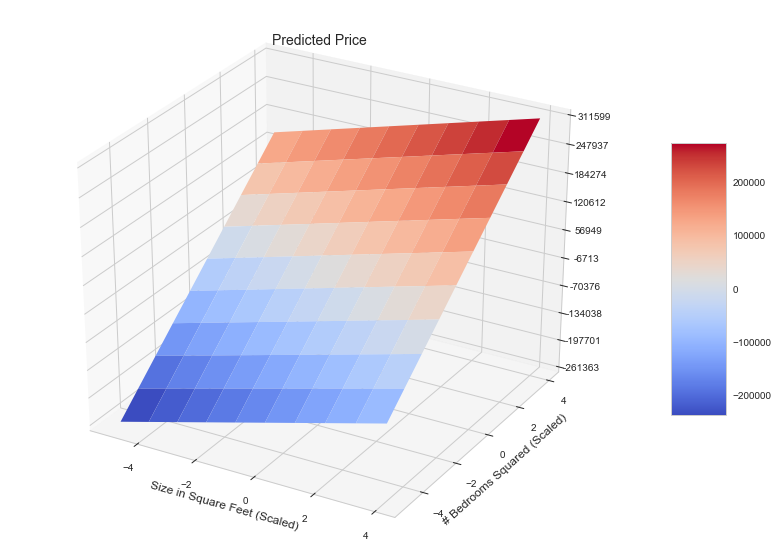

In [26]:
'''
from https://matplotlib.org/mpl_toolkits/mplot3d/tutorial.html
======================
3D surface (color map)
======================

Demonstrates plotting a 3D surface colored with the coolwarm color map.
The surface is made opaque by using antialiased=False.

Also demonstrates using the LinearLocator and custom formatting for the
z axis tick labels.
'''

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np


fig = plt.figure(figsize=(14,10))
ax = fig.gca(projection='3d')

# Make data.
X = np.arange(-5, 5, 1)
Y = np.arange(-5, 5, 1)
X, Y = np.meshgrid(X, Y)
#R = np.sqrt(X**2 + Y**2)
#Z = np.sin(R)
Z = W_opt_display[0] + W_opt_display[1] * X + W_opt_display[2] * Y

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=True)

plt.xlabel('Size in Square Feet (Scaled)', fontsize=12)
plt.ylabel('# Bedrooms Squared (Scaled)', fontsize=12)
plt.title('Predicted Price', fontsize=14)

# Customize the z axis.
#ax.set_zlim(100000, 1000000)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.0f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

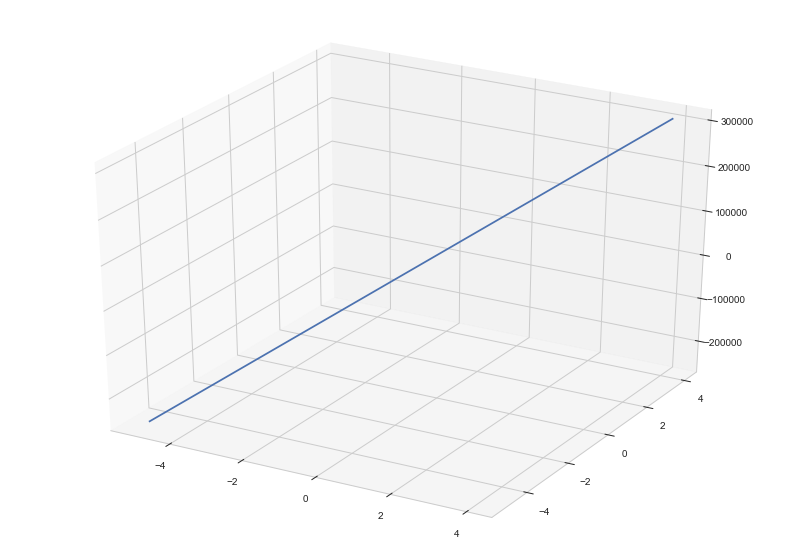

In [27]:
'''
From https://matplotlib.org/mpl_toolkits/mplot3d/tutorial.html
=================
3D wireframe plot
=================

A very basic demonstration of a wireframe plot.
'''

from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt


fig = plt.figure(figsize=(14,10))
ax = fig.add_subplot(111, projection='3d')

# Grab some test data.
#X, Y, Z = axes3d.get_test_data(0.05)
X = np.arange(-5, 5, 1)
Y = np.arange(-5, 5, 1)
Z = W_opt_display[0] + W_opt_display[1] * X + W_opt_display[2] * Y

# Plot a basic wireframe.
ax.plot_wireframe(X, Y, Z, rstride=1, cstride=1)

plt.show()

### Non-Linear Regression in Orange - Demonstration

In [28]:
# More complicated models -- what the dataset looks like

## Step 7: Measure the Performance of the Model(s)

We're going to delay this step until later on in the course.

## Summary

- A model in machine learning is a scheme for transforming the inputs (the features) into an output.
- When it uses just a single feature it is a single-feature model (no surprise!)
- When it uses more than one feature it is a model with multiple features.
- When it uses new features that are constructed using non-linear combinations of features of the dataset, the model is non-linear.
- To run non-linear regressions we must alter the dataset in ways that mirror the model. Specifically, each feature that appears in the model must also appear as a column of values in the dataset. The scheme of transforming features to the output is still just consists of multiplication and addition. But now it involves features that are manufactured to be non-linear combinations of existing features.